In [113]:
from functools import partial
import xgboost as xgb
import pandas as pd
import numpy as np
import re
from inspect import getmro
from sklearn.metrics import accuracy_score,confusion_matrix, roc_auc_score, f1_score, calinski_harabasz_score, davies_bouldin_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from operator import itemgetter
from itertools import islice
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
import statsmodels.api as sm
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

#import tensorflow as tsf

import warnings

warnings.filterwarnings('ignore')

#print(f'Found TF-DF: {tsf.__version__}')

In [114]:
class DataDigest:

    def __init__(self):
        self.ages = None
        self.fares = None
        self.titles = None
        self.cabins = None
        self.families = None
        self.tickets = None

def get_title(name):
    if pd.isnull(name):
        return "Null"

    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1).lower()
    else:
        return "None"
    
def get_index(item, index):
    if pd.isnull(item):
        return -1

    try:
        return index.get_loc(item)
    except KeyError:
        return -1


def get_family(row):
    last_name = row["Name"].split(",")[0]
    if last_name:
        family_size = 1 + row["Parch"] + row["SibSp"]
        if family_size > 3:
            return "{0}_{1}".format(last_name.lower(), family_size)
        else:
            return "nofamily"
    else:
        return "unknown"

    
data_digest = DataDigest()
data_digest.ages = all_data.groupby("Sex")["Age"].median()
data_digest.fares = all_data.groupby("Pclass")["Fare"].median()
data_digest.titles = pd.Index(test["Name"].apply(get_title).unique())
data_digest.families = pd.Index(test.apply(get_family, axis=1).unique())
data_digest.cabins = pd.Index(test["Cabin"].fillna("unknown").unique())
data_digest.tickets = pd.Index(test["Ticket"].fillna("unknown").unique())


def preposition(df):
    df = df.copy()
    
    def nornalise_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
    
    def ticket_item(x):
        item = x.split(" ")
        if len(item) == 1:
            return "None"
        else:
            return "_".join(item[0:-1])
        
    df['Name'] = df['Name'].apply(nornalise_name)
    df['Ticket_number'] = df['Ticket'].apply(ticket_number)
    df['Ticket_item'] = df['Ticket'].apply(ticket_item)
    
    return df

def Preprocessing(train_data):
    #Deal with Missing values, for Embarked, fill with the value that occurs the most
    #train_data['Cabin'].fillna("N0",inplace=True)
    train_data['Age'].fillna(train_data['Age'].mean(),inplace=True)
    train_data['Fare'].fillna(train_data['Fare'].mean(),inplace=True)
    train_data['Embarked'].fillna(train_data['Embarked'].mode()[0],inplace=True)
    train_data['Embarked'] = train_data['Embarked'].astype('str')

    #Maybe Cabin have information as which part of the boat the individual was located,and relate to the survival rate, Due to the complexity of how this is logged,we will use the section letter
    #train_data['Cabin_Section']=train_data['Cabin'].map(lambda x:x[0])
    #The Cabin info in hard to be utilized, meanwhile, train & test data have diff cabin numbers, and there's 75% of missing values in cabin, we will just drop this column
    
    col_for_lble = ['Sex',
                   'Embarked']
    original_dict = {}
    encoder = LabelEncoder()
    for i in col_for_lble:
        train_data[i] = encoder.fit_transform(train_data[i])
        original_dict[i] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        
    return train_data, original_dict
    

def Preprocessing2(train_data):
    #Drop columns that are not informative
    train_data = train_data.drop(['Cabin','Name','Ticket','Ticket_number','Ticket_item','SexF','EmbarkedF','AgeR'],axis=1)
    columns = [i for i in train_data.columns if i in ['Sex','Embarked','Pclass', 'Parch'] or 'cluster_' in i]
               #+ ['Cabin','Name','Ticket','Ticket_number','Ticket_item']
    #get_dumm = pd.get_dummies(train_data[columns], columns=columns)
    train_data['weight'] = create_weight(train_data)
    train_data = train_data.drop(columns +['PassengerId'], axis=1)
    train_data['Age'] = round(train_data['Age'],2)
    train_data['Fare'] = round(train_data['Fare'],3)
    #Convert Dummy variables 
    return train_data

def get_class_name(cls):
    names = [base.__name__ for base in getmro(cls)]
    return names[0]

def is_subset(lst1, comb_list):
    try_list = []
    for i in comb_list:
        if len(lst1) == len(i):
            try_list.append(i)

    search_len = len(lst1)
    counts = []
    for j in try_list:
        count = 0
        for elem in lst1:
            if elem in j:
                count+=1
            else:
                pass
                counts.append(count)
    if search_len in counts:
        return False
    else:
        return True
    
    
def create_combined_list(df):
    import random
    num_columns = df.shape[1]
    combined_list = []
    
    number=5000
    for _ in range(number):
        num_cols = random.randint(2, 6)
        indices = random.sample(range(num_columns), num_cols)
        column_names = df.columns[indices].tolist()
        combined_list.append(column_names)
        if column_names in combined_list:
            number+=1
        if used_list(column_names) != 0:
            number+=1
        elif is_subset(column_names, combined_list) == False:
            combined_list.remove(column_names)
            number+=1
    
    return combined_list


def find_best_ratio(dataframe):
    best_coeff_1 = float('-inf')
    best_coeff_2 = float('inf')
    best_clusters = 0
    
    for index, row in dataframe.iterrows():
        clusters = row['кластер']
        coeff_1 = row['Калиский-Харабаср, больше лучше']
        coeff_2 = row['Дэвид-Болдуин, меньше-лучше']
        
        if coeff_1 > best_coeff_1 and coeff_2 < best_coeff_2:
            best_coeff_1 = coeff_1
            best_coeff_2 = coeff_2
            best_clusters = clusters
    
    return best_clusters

def create_clusters(dict, df):
    count = 0
    for i, j in zip(dict.values(), dict.keys()):
        model = KMeans(n_clusters=i[0],init ='random',n_init='auto')
        model.fit(df[i[1]])
        df[f'cluster_{j}'] = model.labels_
#        if df[f'cluster_{j}'].corr(df['Survived'])*100 >= 3:
#            pass
#        else:
#            df = df.drop([f'cluster_{j}'],axis=1)
    return df

def used_list(list):    
    with open(r'C:\Users\aleksandrovva1\Desktop\titanic\used_pairs.txt', 'r') as file:
        lines = file.readlines()
        found_values = []
        for line in lines:
            line = line.strip()
            if line in str(list):
                found_values.append(line)
    return len(found_values)

def find_cluster_list(dict_: dict):
    find = []
    for i in list(dict_.values()):
        find.append(i[1])
    return find


def create_weight(df):
    df['weight'] = df.apply(lambda x: assign_weight(x['Pclass']), axis=1)
    return df['weight']

def assign_weight(pclass):
    if pclass == 3:
        return 1
    elif pclass == 2:
        return 2
    elif pclass == 1:
        return 3


    
    
def munge_data(data, digest):
    # Age - замена пропусков на медиану в зависимости от пола
    data["AgeF"] = data.apply(lambda r: digest.ages[r["Sex"]] if pd.isnull(r["Age"]) else r["Age"], axis=1)

    # Fare - замена пропусков на медиану в зависимости от класса
    data["FareF"] = data.apply(lambda r: digest.fares[r["Pclass"]] if pd.isnull(r["Fare"]) else r["Fare"], axis=1)

    # Gender - замена
    genders = {"male": 1, "female": 0}
    data["SexF"] = data["Sex"].apply(lambda s: genders.get(s))

    # Gender - расширение
    gender_dummies = pd.get_dummies(data["Sex"], prefix="SexD", dummy_na=False)
    data = pd.concat([data, gender_dummies], axis=1)

    # Embarkment - замена
    embarkments = {"U": 0, "S": 1, "C": 2, "Q": 3}
    data["EmbarkedF"] = data["Embarked"].fillna("U").apply(lambda e: embarkments.get(e))

    # Embarkment - расширение
    embarkment_dummies = pd.get_dummies(data["Embarked"], prefix="EmbarkedD", dummy_na=False)
    data = pd.concat([data, embarkment_dummies], axis=1)

    # Количество родственников на борту
    data["RelativesF"] = data["Parch"] + data["SibSp"]

    # Человек-одиночка?
    data["SingleF"] = data["RelativesF"].apply(lambda r: 1 if r == 0 else 0)

    # Deck - замена
    decks = {"U": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
    data["DeckF"] = data["Cabin"].fillna("U").apply(lambda c: decks.get(c[0], -1))

    # Deck - расширение
    deck_dummies = pd.get_dummies(data["Cabin"].fillna("U").apply(lambda c: c[0]), prefix="DeckD", dummy_na=False)
    data = pd.concat([data, deck_dummies], axis=1)

    # Titles - расширение
    title_dummies = pd.get_dummies(data["Name"].apply(lambda n: get_title(n)), prefix="TitleD", dummy_na=False)
    data = pd.concat([data, title_dummies], axis=1)

    # амена текстов на индекс из соответствующего справочника или -1 если значения в справочнике нет (расширять не будем)
    data["CabinF"] = data["Cabin"].fillna("unknown").apply(lambda c: get_index(c, digest.cabins))

    data["TitleF"] = data["Name"].apply(lambda n: get_index(get_title(n), digest.titles))

    data["TicketF"] = data["Ticket"].apply(lambda t: get_index(t, digest.tickets))

    data["FamilyF"] = data.apply(lambda r: get_index(get_family(r), digest.families), axis=1)

    # для статистики
    age_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90]
    data["AgeR"] = pd.cut(data["Age"].fillna(-1), bins=age_bins).astype(object)

    return data

In [115]:
test = pd.read_csv(r'C:\Users\aleksandrovva1\Desktop\titanic\test.csv')
train = pd.read_csv(r'C:\Users\aleksandrovva1\Desktop\titanic\train.csv')
passage = test['PassengerId']
all_data = pd.concat([train, test])

In [116]:
unique_list = {0: [5, ['Sex', 'Embarked'], -54.77049946777053],
 1: [12, ['Sex', 'Parch'], -54.47400538579452],
 6: [11, ['Parch', 'Sex'], 53.33756781517999],
 9: [14, ['SibSp', 'Pclass', 'Sex'], -55.12692610004996],
 10: [5, ['Sex', 'Pclass'], 50.745756738870405],
 13: [14, ['Embarked', 'Parch', 'Sex'], 51.29933341612405],
 17: [10, ['Parch', 'Sex', 'SibSp'], 50.168970398268364]}

In [117]:
court = 0
preproc_train = preposition(train)
preproc_test = preposition(test)
preproc_train, dict_for_train = Preprocessing(preproc_train)
preproc_test, dict_for_test= Preprocessing(preproc_test)

preproc_train = munge_data(preproc_train, data_digest)
preproc_train = Preprocessing2(preproc_train)
preproc_test = munge_data(preproc_test, data_digest)
preproc_test = Preprocessing2(preproc_test)
all_data_munged = pd.concat([preproc_train, preproc_test])

In [118]:
predictors = ["Pclass",
              "AgeF",
              "TitleF",
              "TitleD_mr", "TitleD_mrs", "TitleD_miss", "TitleD_master", "TitleD_ms", 
              "TitleD_col", "TitleD_rev", "TitleD_dr",
              "CabinF",
              "DeckF",
              "DeckD_U", "DeckD_A", "DeckD_B", "DeckD_C", "DeckD_D", "DeckD_E", "DeckD_F", "DeckD_G",
              "FamilyF",
              "TicketF",
              "SexF",
              "SexD_male", "SexD_female",
              "EmbarkedF",
              "EmbarkedD_S", "EmbarkedD_C", "EmbarkedD_Q",
              "FareF",
              "SibSp", "Parch",
              "RelativesF",
              "SingleF"]
target = 'Survived'

In [107]:
preproc_train.columns

Index(['Survived', 'Age', 'SibSp', 'Fare', 'AgeF', 'FareF', 'SexD_0', 'SexD_1',
       'EmbarkedD_0', 'EmbarkedD_1', 'EmbarkedD_2', 'RelativesF', 'SingleF',
       'DeckF', 'DeckD_A', 'DeckD_B', 'DeckD_C', 'DeckD_D', 'DeckD_E',
       'DeckD_F', 'DeckD_G', 'DeckD_T', 'DeckD_U', 'TitleD_None', 'CabinF',
       'TitleF', 'TicketF', 'FamilyF', 'weight'],
      dtype='object')

In [120]:
#fff = create_clusters(unique_list, preproc_train)
#preproc_train = Preprocessing2(preproc_train)
columns_for_change = [i for i in preproc_train if i not in ['Survived','Age','Fare','Pclass_','Sex_', 'SexF','EmbarkedF'] 
                      and 'Sex_' not in i 
                      and 'Pclass_' not in i]
#for column in columns_for_change:
#    preproc_train[column+'_weight'] = preproc_train[column]/preproc_train['weight']
preproc_train = preproc_train.drop(['DeckD_T'],axis=1)

In [121]:
columns_for_train_model = [i for i in preproc_train.columns if i not in ['Survived']]
target = 'Survived'   
train_x, test_x, train_y, test_y = train_test_split(preproc_train[columns_for_train_model],
                                                    preproc_train[target], 
                                                    random_state=42, 
                                                    train_size=0.7,
                                                    shuffle=True,
                                                    stratify=preproc_train[target])

In [122]:
classes = np.unique(train_y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y)
class_weights = dict(zip(classes, weights))
model = CatBoostClassifier(iterations=250,
                           class_weights=class_weights,
                           depth=2, 
                           verbose=False, 
                           learning_rate=0.02,
                           use_best_model=True, 
                           leaf_estimation_method='Newton', 
                           l2_leaf_reg=0.3, 
                           border_count=13,
                           eval_metric='AUC'
                              )
model.fit(train_x, train_y,
         eval_set=(train_x, train_y),
         plot=True)
pred = model.predict_proba(test_x)[:,1]
roc_auc_score(test_y, pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8594586643130333

In [14]:
models = [RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, CatBoostClassifier, SVC, AdaBoostClassifier]
scores = {}
for j in range(1,15,1):
    for i in models:
        if i == CatBoostClassifier:
            model = i(verbose=0).fit(train_x, train_y)
        else:
            model = i().fit(train_x, train_y)
        pred = model.predict(test_x)
        scores.setdefault(get_class_name(i), []).append(roc_auc_score(pred, test_y))

In [15]:
for i in pd.DataFrame(scores).columns:
    print('****'*20)
    print(f'расхождение по обучению по колонке {i} : {np.std(pd.DataFrame(scores)[i])}')
    print(f'среднее по обучению по колонке {i} : {np.mean(pd.DataFrame(scores)[i])}')
    print('****'*20)

********************************************************************************
расхождение по обучению по колонке RandomForestClassifier : 0.009436554535893394
среднее по обучению по колонке RandomForestClassifier : 0.7956198804617794
********************************************************************************
********************************************************************************
расхождение по обучению по колонке LogisticRegression : 1.1102230246251565e-16
среднее по обучению по колонке LogisticRegression : 0.787827715355805
********************************************************************************
********************************************************************************
расхождение по обучению по колонке DecisionTreeClassifier : 0.0053969340639694035
среднее по обучению по колонке DecisionTreeClassifier : 0.7473127866662843
********************************************************************************
****************************************************

In [128]:
kernels = np.arange(0.01,1,0.01)
scores = []

for i in kernels:
    model = LogisticRegression(
    max_iter = 7,
    C=13.8,
    tol = 0.001,
    solver = 'liblinear',
    penalty = 'l2'
    ).fit(train_x, train_y)
    preds = model.predict_proba(test_x)[:,1]
    scores.append(roc_auc_score(test_y, preds))

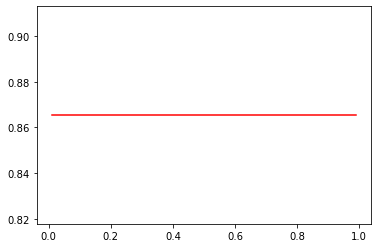

In [129]:
plt.plot(kernels,scores, c='red')
#plt.xlim([5,20])
plt.show()

In [126]:
svc = SVC(
    C=4.4,
    coef0 = 0.79,
    class_weight=class_weights,
    degree = 5,
    probability=True
).fit(train_x, train_y)
pred = svc.predict_proba(test_x)[:,1]
print(type(svc).__name__, '   :',roc_auc_score(test_y, pred))


catboost = CatBoostClassifier(iterations=250,
                           class_weights=class_weights,
                           depth=2, 
                           verbose=False, 
                           learning_rate=0.02,
                           use_best_model=True, 
                           leaf_estimation_method='Newton', 
                           l2_leaf_reg=0.3, 
                           border_count=13,
                           eval_metric='AUC'
                              )
catboost.fit(train_x, train_y,
         eval_set=(train_x, train_y),
         plot=True)
pred = catboost.predict_proba(test_x)[:,1]
print(type(catboost).__name__, '   :',roc_auc_score(test_y, pred))

logistic = LogisticRegression(
    class_weight=class_weights,
    max_iter = 7,
    C=13.8,
    tol = 0.001,
    solver = 'liblinear',
    penalty = 'l2'
    ).fit(train_x, train_y)
pred = logistic.predict_proba(test_x)[:,1]
print(type(logistic).__name__, '   :',roc_auc_score(test_y, pred))

rfr = RandomForestClassifier(
    class_weight=class_weights,
    bootstrap= False,
    criterion= 'log_loss',
    max_depth= 7,
    min_samples_leaf= 24,
    min_samples_split= 24,
    n_estimators= 40
).fit(train_x, train_y)
pred = rfr.predict_proba(test_x)[:,1]
print(type(rfr).__name__, '   :',roc_auc_score(test_y, pred))

destree = DecisionTreeClassifier(
    class_weight=class_weights,
    ccp_alpha= 0.01,
    criterion= 'gini',
    max_depth= 7,
    min_samples_leaf= 17,
    min_samples_split= 17,
    splitter= 'best'
).fit(train_x, train_y)
pred = destree.predict_proba(test_x)[:,1]
print(type(destree).__name__, '   :',roc_auc_score(test_y, pred))

SVC    : 0.7663724624889673


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostClassifier    : 0.8650485436893205
LogisticRegression    : 0.8561047366872611
RandomForestClassifier    : 0.8585760517799353
DecisionTreeClassifier    : 0.8297734627831715


In [65]:
rfr_params

{'bootstrap': False,
 'criterion': 'log_loss',
 'max_depth': 7,
 'min_samples_leaf': 24,
 'min_samples_split': 24,
 'n_estimators': 40}

In [138]:
params = {
    'max_iter' : np.arange(1,100,1),
    'C':np.arange(0.1,30,0.1),
    'tol': [0.001,0.01,0.1,0.0001,0.00001,0.000001,0.0000001,0.00000001]
           }

classes = np.unique(train_y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_y)
class_weights = dict(zip(classes, weights))

model = LogisticRegression(class_weight=class_weights, 
                           solver = 'liblinear',
                           penalty = 'l2')

rs = RandomizedSearchCV(model, params, cv=3, random_state=42, scoring='roc_auc', n_iter=300).fit(train_x, train_y)
print(rs.best_params_)
print(rs.best_score_)

{'tol': 0.1, 'max_iter': 91, 'C': 0.5}
0.8449340305247891


In [86]:
def objective(params):
    model = MLPClassifier(**params)
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    score = accuracy_score(test_y, pred)
    return {'loss': -score, 'params':params, 'status': STATUS_OK}


search_space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(100,), (100,100), (100,100,100), (100,100,100,100)]),
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'alpha': hp.choice('alpha', [0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001]),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'max_iter': hp.choice('max_iter', np.arange(100,10000,100)),
    'batch_size': hp.choice('batch_size', np.arange(10,150, 10)),
    'validation_fraction': hp.choice('validation_fraction', np.arange(0,1,0.01)),
    'beta_1': hp.choice('beta_1', np.arange(0.01,1,0.01)),
    'beta_2': hp.choice('beta_2', np.arange(0.01,1,0.01))
}


trial_neural = Trials()
best = fmin(fn=objective, 
            space=search_space, 
            algo = tpe.suggest,
            max_evals=10000,
            trials=trial_neural)

100%|███████████████████████████████████████| 10000/10000 [7:37:36<00:00,  2.75s/trial, best loss: -0.8283582089552238]


In [123]:
def objective(params):
    model = xgb.XGBClassifier(**params)
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    score = accuracy_score(test_y, pred)
    return {'loss': -score, 'params':params, 'status': STATUS_OK}


search_space = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.01,0.3,0.01)),
    'n_estimators': hp.choice('n_estimators', np.arange(100,1000,100)),
    'max_depth': hp.choice('max_depth', np.arange(1,10,1)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1,10,1)),
    'gamma': hp.choice('gamma', np.arange(0.01,1,0.01)),
    'subsample': hp.choice('subsample', np.arange(0.5,1, 0.1)),
    'colsample_bytree': hp.choice('colsample_bytree ', np.arange(0.5,1, 0.1))
}


trial_xgb = Trials()
best = fmin(fn=objective, 
            space=search_space, 
            algo = tpe.suggest,
            max_evals=10000,
            trials=trial_xgb)

100%|█████████████████████████████████████████| 10000/10000 [45:02<00:00,  3.70trial/s, best loss: -0.8395522388059702]


In [128]:
xbb = xgb.XGBClassifier(**xgb_params).fit(preproc_train[columns_for_train_model], preproc_train[target])
pred = xbb.predict(preproc_test)

In [132]:
mlp = MLPClassifier(**neural_params).fit(preproc_train[columns_for_train_model], preproc_train[target])
pred = mlp.predict(preproc_test)

In [124]:
trial_xgb.best_trial['result']

{'loss': -0.8395522388059702,
 'params': {'colsample_bytree': 0.6,
  'gamma': 0.5800000000000001,
  'learning_rate': 0.06999999999999999,
  'max_depth': 2,
  'min_child_weight': 1,
  'n_estimators': 500,
  'subsample': 0.8999999999999999},
 'status': 'ok'}

In [126]:
xgb_params = trial_xgb.best_trial['result']['params']

In [127]:
neural_params = trial_neural.best_trial['result']['params']

In [ ]:
def objective(params):
    model = MLPClassifier(**params)
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    score = accuracy_score(test_y, pred)
    return {'loss': -score, 'params':params, 'status': STATUS_OK}


search_space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(100,), (100,100), (100,100,100), (100,100,100,100)]),
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'alpha': hp.choice('alpha', [0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001]),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'max_iter': hp.choice('max_iter', np.arange(100,10000,100)),
    'batch_size': hp.choice('batch_size', np.arange(10,150, 10)),
    'validation_fraction': hp.choice('validation_fraction', np.arange(0,1,0.01)),
    'beta_1': hp.choice('beta_1', np.arange(0.01,1,0.01)),
    'beta_2': hp.choice('beta_2', np.arange(0.01,1,0.01))
}


trial = Trials()
best = fmin(fn=objective, 
            space=search_space, 
            algo = tpe.suggest,
            max_evals=10000,
            trials=trial)

In [42]:
for i,j in trial.best_trial['result']['params'].items():
    print(i,'=',j,',')

activation = logistic ,
alpha = 0.1 ,
batch_size = 140 ,
hidden_layer_sizes = (100, 100, 100, 100) ,
learning_rate = adaptive ,
max_iter = 2200 ,
validation_fraction = 0.19 ,


In [45]:
params = trial.best_trial['result']['params']

In [ ]:
ensemble = VotingClassifier(estimators=[('svc', svc), ('logistic', logistic), ('rfr', rfr), ('destree', destree),
                                       ('catboost', catboost)], voting='soft').fit(train_x, train_y)

In [46]:
mlp = MLPClassifier(**params).fit(train_x, train_y)
pred = mlp.predict_proba(test_x)[:,1]
roc_auc_score(test_y, pred)

0.8636363636363635

In [49]:
mlp.get_params()

{'activation': 'logistic',
 'alpha': 0.1,
 'batch_size': 140,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100, 100, 100, 100),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 2200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.19,
 'verbose': False,
 'warm_start': False}

In [59]:
params['beta_1'] = 0.22
params['beta_2'] = 0.21

In [56]:
beta1 = np.arange(0.1,1.1,0.1)
beta2 = np.arange(0.01,1.01,0.01)
def objective(params):
    model = MLPClassifier(**params,
                         activation = 'logistic' ,
                         alpha = 0.1 ,
                         batch_size = 140 ,
                         hidden_layer_sizes = (100, 100, 100, 100) ,
                         learning_rate = 'adaptive' ,
                         max_iter = 2200 ,
                         validation_fraction = 0.19)
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    score = roc_auc_score(test_y, pred)
    return {'loss': -score, 'params':params, 'status': STATUS_OK}


search_space = {
    'beta_1': hp.choice('beta_1', np.arange(0.01,1,0.01)),
    'beta_2': hp.choice('beta_2', np.arange(0.01,1,0.01))
}


trial1 = Trials()
best = fmin(fn=objective, 
            space=search_space, 
            algo = tpe.suggest,
            max_evals=2000,
            trials=trial1)

100%|███████████████████████████████████████████| 2000/2000 [56:44<00:00,  1.70s/trial, best loss: -0.8101206237128569]


In [57]:
trial1.best_trial['result']['params']

{'beta_1': 0.22, 'beta_2': 0.21000000000000002}

In [104]:
mlp = MLPClassifier(**params).fit(fff[columns_for_train_model], fff[target])
#pred = mlp.predict_proba(test_x)[:,1]
#roc_auc_score(test_y, pred)

In [70]:
cross_val_score(CatBoostClassifier(iterations=250,
                           class_weights=class_weights,
                           depth=2, 
                           verbose=False, 
                           learning_rate=0.02, 
                           leaf_estimation_method='Newton', 
                           l2_leaf_reg=0.3, 
                           border_count=13
                              ), fff[columns_for_train_model], fff[target], scoring='roc_auc', cv=3)

array([0.81564567, 0.87208801, 0.88009299])

In [105]:
pred = mlp.predict(preproc_test)

In [107]:
predict = pd.DataFrame({
    'PassengerId': passage,
    'Survived': pred
})
predict.to_csv(r'C:\Users\aleksandrovva1\Desktop\titanic\gender_submission.csv',index=False)

In [110]:
catboost = CatBoostClassifier(iterations=250,
                           class_weights=class_weights,
                           depth=2, 
                           verbose=False, 
                           learning_rate=0.02,
                           use_best_model=True, 
                           leaf_estimation_method='Newton', 
                           l2_leaf_reg=0.3, 
                           border_count=13,
                           eval_metric='AUC'
                              )
catboost.fit(fff[columns_for_train_model], fff[target],eval_set=(fff[columns_for_train_model], fff[target]), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [111]:
pred = catboost.predict(preproc_test)

In [133]:
predict = pd.DataFrame({
    'PassengerId': passage,
    'Survived': pred
})
predict.to_csv(r'C:\Users\aleksandrovva1\Desktop\titanic\gender_submission.csv',index=False)